### IDENTIFYING THE BEST PLAYERS IN TERMS OF PASSES THAT LEAD TO A SHOT OR GOAL IN THE WORLD CUP 2022

In [4]:
from statsbombpy import sb
import pandas as pd
import numpy as np

##### Read and clean the data

In [2]:
# Read the WC 2022 data
df=pd.DataFrame(sb.matches(competition_id=43, season_id=106))

passes_global = pd.DataFrame()  # DataFrame for the passes
shots_global = pd.DataFrame()   # DataFrame for the shots

for match in df.match_id.unique():
    event = sb.events(match_id=match)
    passes = event[event['type']=='Pass']
    shots = event[event['type']=='Shot']

    passes_global = pd.concat([passes_global, passes], ignore_index=True)
    shots_global = pd.concat([shots_global, shots], ignore_index=True)


c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\Gabriel\anaconda3\Lib\site-pack

##### Get the passes that lead to a shot or goal

In [3]:
# Filter for passes that lead to a shot or a goal
goal_and_shot_assists = passes_global[(passes_global['pass_goal_assist'] == True) | (passes_global['pass_shot_assist'] == True)]

# Get the interested columns
goal_and_shot_assists = goal_and_shot_assists[['id','location','pass_assisted_shot_id','pass_end_location',
                                              'player','position','team','pass_goal_assist','pass_shot_assist','play_pattern']]


##### Get the shots from passes

In [5]:
# Get the xG of the shots from passes
players_xg = pd.DataFrame(columns=['player', 'team', 'xG','play_pattern'])

for index, row in goal_and_shot_assists.iterrows():
    player = row['player']
    play_pattern = row['play_pattern']
    id_shot = row['pass_assisted_shot_id']
    team = row['team']
    for shot in shots_global.id.unique():
        if id_shot == shot:
            xG = shots_global[shots_global['id'] == id_shot]['shot_statsbomb_xg'].values[0]
            data = {'player': player, 'team': team, 'xG': xG, 'play_pattern':play_pattern}
            data = pd.DataFrame([data])
            players_xg = pd.concat([players_xg, data], ignore_index=True)

# Identify which play patterns are regular plays and which are set pieces
regular_plays = ['Regular Play', 'From Counter','Other','From Keeper','From Goal Kick','From Kick Off']
players_xg['play_pattern'] = np.where(players_xg['play_pattern'].isin(regular_plays), 'Regular Play', 'Setpieces')

#Player = Player - Team
players_xg['player'] = players_xg['player'] + ' - ' + players_xg['team']
display(players_xg.head())

,player,team,xG,play_pattern
0,Xherdan Shaqiri - Switzerland,Switzerland,0.353289,Regular Play
1,Dušan Tadić - Serbia,Serbia,0.081609,Setpieces
2,Dušan Tadić - Serbia,Serbia,0.030002,Regular Play
3,Ruben Vargas - Switzerland,Switzerland,0.096118,Setpieces
4,Djibril Sow - Switzerland,Switzerland,0.069699,Setpieces


##### Identify the players with the most xG from their passes

In [44]:
top = players_xg.groupby('player', as_index=False)['xG'].sum().sort_values(by='xG', ascending=False)
top_players = top['player'].head(10).tolist()
display(top_players)

['Antoine Griezmann - France',
 'Lionel Andrés Messi Cuccittini - Argentina',
 'Leroy Sané - Germany',
 'Raphael Dias Belloli - Brazil',
 'Harry Kane - England',
 'Ousmane Dembélé - France',
 'Mateo Kovačić - Croatia',
 'Bruno Miguel Borges Fernandes - Portugal',
 'Hirving Rodrigo Lozano Bahena - Mexico',
 'Mislav Oršić - Croatia']

##### Barchart of the xG from each player for each play pattern (Regular Play, Set pieces)

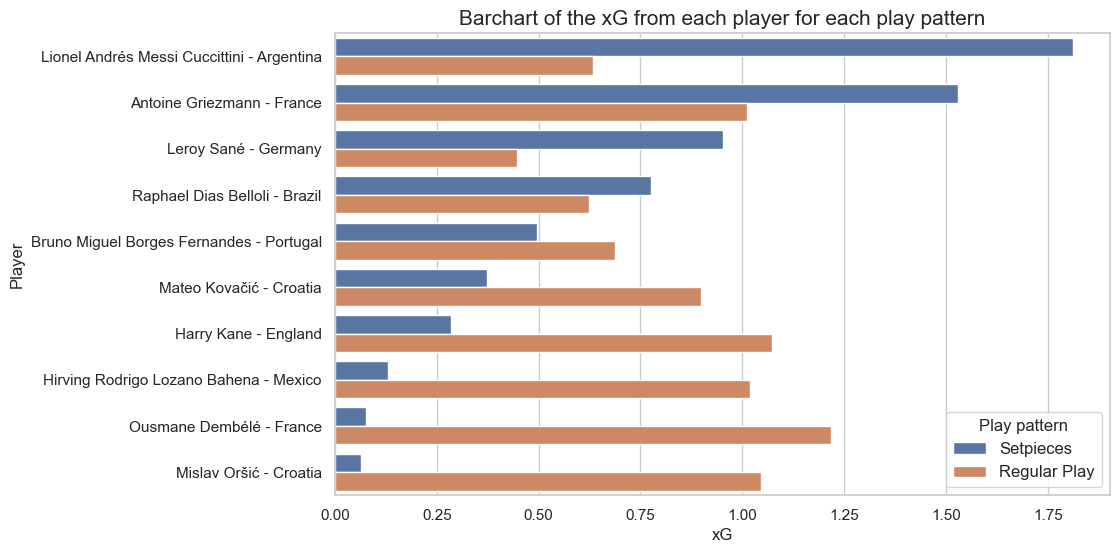

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

data = players_xg[players_xg['player'].isin(top_players)]
data = data.groupby(['player','play_pattern'])['xG'].sum().reset_index()
data = data.sort_values(by=['play_pattern','xG'], ascending=False)

plt.figure(figsize=(10, 6)) 
sns.set(style="whitegrid")

plot = sns.barplot(x='xG', y='player', hue='play_pattern', data=data, orient='h')

plt.xlabel('xG')
plt.ylabel('Player')
plt.title('Barchart of the xG from each player for each play pattern',fontsize=15)
plt.legend(title='Play pattern',loc='lower right', fontsize='medium')

plt.savefig('../img/BarchartXGPlayer.png')

plt.show()


#### ANALYSING THE PASSES FROM THE BEST PLAYERS OF REGULAR PLAYS

In [24]:
# Get the location, outcome and xG of the shots that came from a pass
shots_global = shots_global[['id','location','shot_end_location','shot_outcome','shot_statsbomb_xg']]
shots = pd.DataFrame(columns=['id','location','shot_end_location','shot_outcome','shot_statsbomb_xg'])

for index, row in goal_and_shot_assists.iterrows():
    id_shot = row['pass_assisted_shot_id']
    for shot in shots_global.id.unique():
        if id_shot == shot:
            shots = pd.concat([shots,shots_global[shots_global['id']==shot]],ignore_index=True)

In [37]:
# Merged the passes and the shots
pass_shot = pd.merge(goal_and_shot_assists,shots,left_on='pass_assisted_shot_id',right_on='id')

# Get only the columns that we want and rename them
columns = ['id_x','location_x','pass_end_location','player','position','team','play_pattern','id_y',
           'location_y','shot_end_location','shot_outcome','shot_statsbomb_xg']
pass_shot = pass_shot[columns]
pass_shot.columns=['id_pass','location_pass','pass_end_location','player','position','team','play_pattern','id_shot',
           'location_shot','shot_end_location','shot_outcome','xG']

# Get only regular plays
regular_plays = ['Regular Play', 'From Counter','Other','From Keeper','From Goal Kick','From Kick Off']
pass_shot['play_pattern'] = np.where(pass_shot['play_pattern'].isin(regular_plays), 'Regular Play', 'Setpieces')

pass_shot_regular = pass_shot[pass_shot['play_pattern']=='Regular Play']
display(pass_shot_regular.head())


,id_pass,location_pass,pass_end_location,player,position,team,play_pattern,id_shot,location_shot,shot_end_location,shot_outcome,xG
0,72ccec71-b08d-4931-bc08-cffee978637f,"[105.6, 47.5]","[113.1, 40.7]",Xherdan Shaqiri,Right Wing,Switzerland,Regular Play,aa77495b-0e7b-44f0-a2eb-11605085943a,"[113.1, 40.7]","[114.8, 40.6, 1.6]",Saved,0.353289
2,792b7a48-0f44-4c21-8372-3511c68845e7,"[103.3, 71.1]","[96.4, 52.4]",Dušan Tadić,Center Attacking Midfield,Serbia,Regular Play,00e599c0-5234-4b6a-9b91-d6f789a311b0,"[97.8, 51.5]","[120.0, 36.1, 0.6]",Post,0.030002
5,8c7a3584-3c55-4cee-85c0-a74db60645a8,"[105.2, 24.9]","[97.3, 33.7]",Ruben Vargas,Left Wing,Switzerland,Regular Play,97f840a8-4545-46a7-a9b3-8e91be859de5,"[97.3, 33.7]","[116.9, 38.7, 0.2]",Saved,0.044765
7,7640f32c-6cc4-4254-b361-3c6fd2b61090,"[100.4, 14.9]","[108.3, 38.6]",Dušan Tadić,Center Attacking Midfield,Serbia,Regular Play,e90ac0da-ac09-4a22-a26e-01ff53f52434,"[108.3, 38.6]","[120.0, 43.3, 0.9]",Goal,0.063718
9,d6620619-2742-4493-9bbe-9764f48fea79,"[109.0, 59.8]","[114.4, 36.9]",Silvan Widmer,Right Back,Switzerland,Regular Play,663eefd5-97eb-4c07-9ac7-241b3bfe1356,"[114.4, 36.9]","[120.0, 37.8, 0.6]",Goal,0.726976


In [38]:
#Convert tuples values into 2 columns
pass_shot_regular = pass_shot_regular.assign(x=pass_shot_regular['location_pass'].str[0], y=pass_shot_regular['location_pass'].str[1])

pass_shot_regular.drop(columns=['location_pass'],inplace=True)

pass_shot_regular = pass_shot_regular.assign(end_x=pass_shot_regular['pass_end_location'].str[0], end_y=pass_shot_regular['pass_end_location'].str[1])

pass_shot_regular.drop(columns=['pass_end_location'],inplace=True)

pass_shot_regular = pass_shot_regular.assign(s_x=pass_shot_regular['location_shot'].str[0], s_y=pass_shot_regular['location_shot'].str[1])

pass_shot_regular.drop(columns=['location_shot'],inplace=True)
pass_shot_regular.drop(columns=['shot_end_location'],inplace=True)

display(pass_shot_regular.head())


,id_pass,player,position,team,play_pattern,id_shot,shot_outcome,xG,x,y,end_x,end_y,s_x,s_y
0,72ccec71-b08d-4931-bc08-cffee978637f,Xherdan Shaqiri,Right Wing,Switzerland,Regular Play,aa77495b-0e7b-44f0-a2eb-11605085943a,Saved,0.353289,105.6,47.5,113.1,40.7,113.1,40.7
2,792b7a48-0f44-4c21-8372-3511c68845e7,Dušan Tadić,Center Attacking Midfield,Serbia,Regular Play,00e599c0-5234-4b6a-9b91-d6f789a311b0,Post,0.030002,103.3,71.1,96.4,52.4,97.8,51.5
5,8c7a3584-3c55-4cee-85c0-a74db60645a8,Ruben Vargas,Left Wing,Switzerland,Regular Play,97f840a8-4545-46a7-a9b3-8e91be859de5,Saved,0.044765,105.2,24.9,97.3,33.7,97.3,33.7
7,7640f32c-6cc4-4254-b361-3c6fd2b61090,Dušan Tadić,Center Attacking Midfield,Serbia,Regular Play,e90ac0da-ac09-4a22-a26e-01ff53f52434,Goal,0.063718,100.4,14.9,108.3,38.6,108.3,38.6
9,d6620619-2742-4493-9bbe-9764f48fea79,Silvan Widmer,Right Back,Switzerland,Regular Play,663eefd5-97eb-4c07-9ac7-241b3bfe1356,Goal,0.726976,109.0,59.8,114.4,36.9,114.4,36.9


In [70]:
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt

# Function to plot the passes of a player
def plot_passes(df,player,team):
    df_pass= df[df['player']==player]
    mask_goal = df_pass.shot_outcome == 'Goal'

    # Setup the pitch
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='whitesmoke', line_color='maroon',
                        half=True, pad_top=2)
    fig, axs = pitch.grid(endnote_height=0.1, endnote_space=0, figheight=8,
                        title_height=0.05, title_space=0, axis=False,
                        grid_height=0.82)

    fig.set_facecolor('whitesmoke')

    # Plot player position
    pitch.scatter(df_pass.x, df_pass.y, s=50,edgecolors='black', c='white', zorder=2,
                label=player, ax=axs['pitch'])

    # Plot the completed passes
    pitch.lines(df_pass.x, df_pass.y, df_pass.end_x, df_pass.end_y,
                lw=3, transparent=True, comet=True, color='red',
                label='pass leading to shot', ax=axs['pitch'])
    pitch.lines(df_pass.end_x, df_pass.end_y, df_pass.s_x, df_pass.s_y,
                lw=3, transparent=True, comet=True, color='blue',
                label='ball handling', ax=axs['pitch'])

    # Plot the goals
    pitch.scatter(df_pass[mask_goal].s_x, df_pass[mask_goal].s_y, s=150,
                marker='football', edgecolors='black', c='white', zorder=2,
                label='goal', ax=axs['pitch'])
    pitch.scatter(df_pass[~mask_goal].s_x, df_pass[~mask_goal].s_y,
                edgecolors='white', c='#22312b', s=100, zorder=2,
                label='miss', ax=axs['pitch'])

    axs['title'].text(0, 1.8, f'{player} passes leading to shots', color='black', va='center', ha='left', fontsize=17)

    axs['title'].text(0, 1.2, team, color='black', va='center', ha='left', fontsize=12)

    goal_count = (df_pass['shot_outcome'] == 'Goal').sum()
    xg = df_pass['xG'].sum().round(2)

    axs['title'].text(0, 0.7, f'Goals: {goal_count}', color='black', va='center', ha='left', fontsize=12)
    axs['title'].text(0, 0.2, f'Expected goals: {xg}', color='black', va='center', ha='left', fontsize=12)

    # Set legend
    legend = axs['pitch'].legend(edgecolor='black',
                                loc='upper right', handlelength=1)
    for text in legend.get_texts():
        text.set_fontsize(10)

    plt.savefig(f"../img/PlotPasses_{player}.png")

    plt.show()

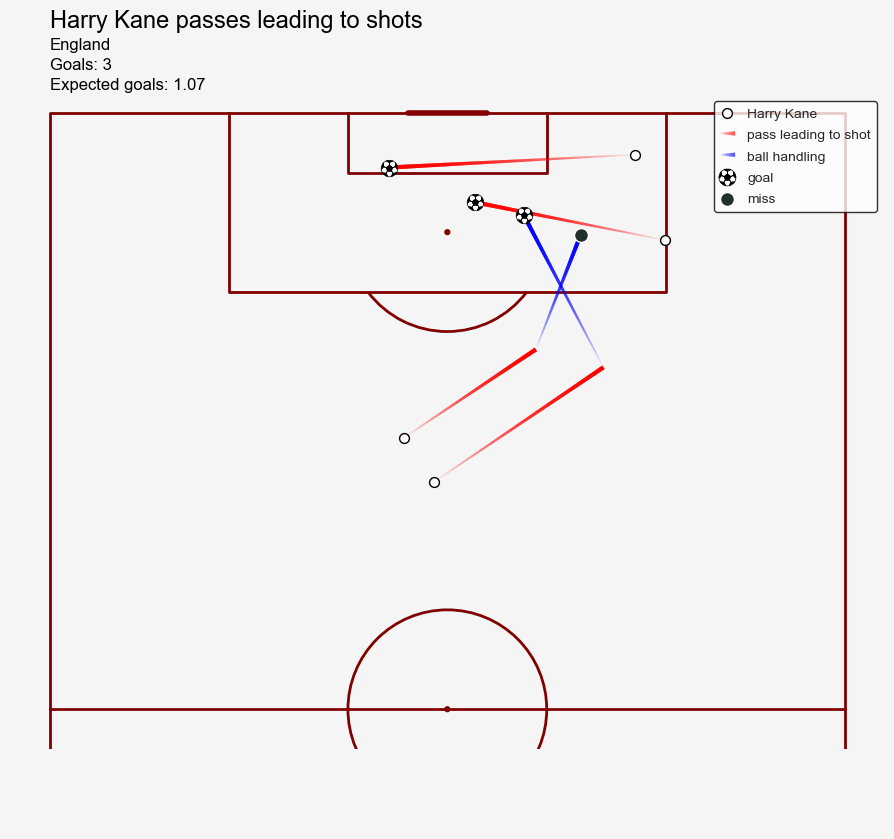

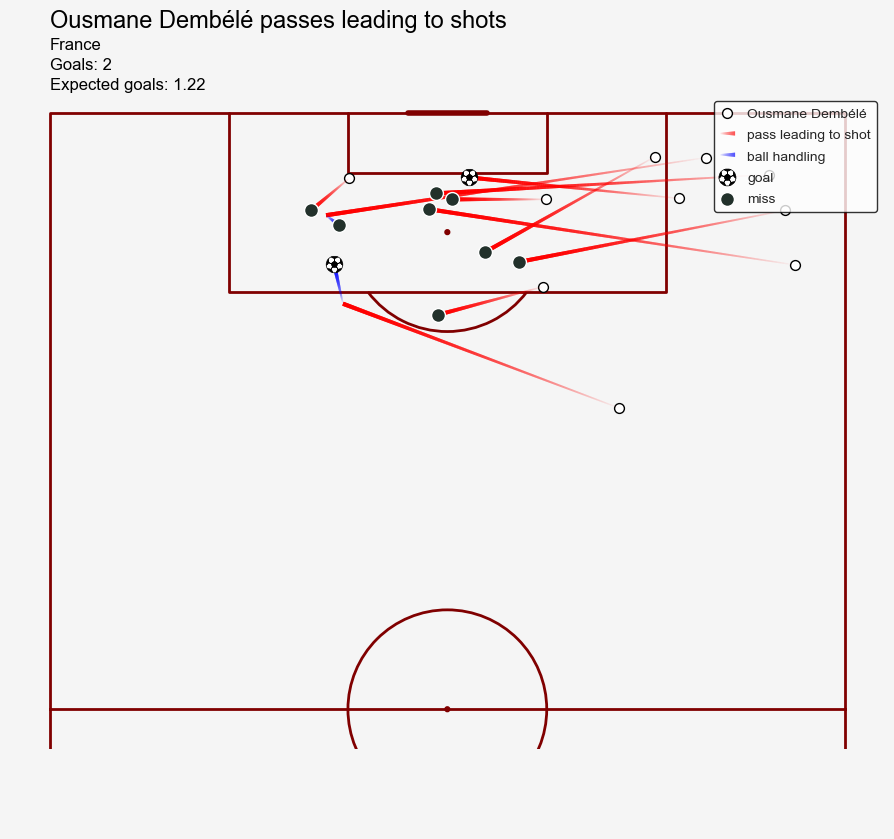

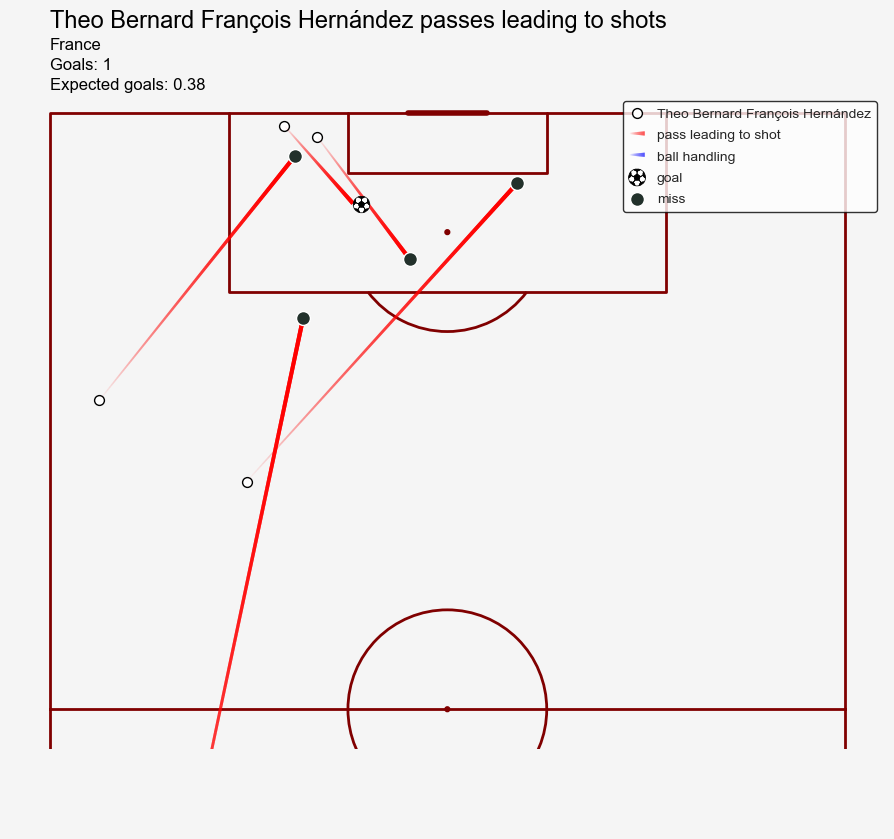

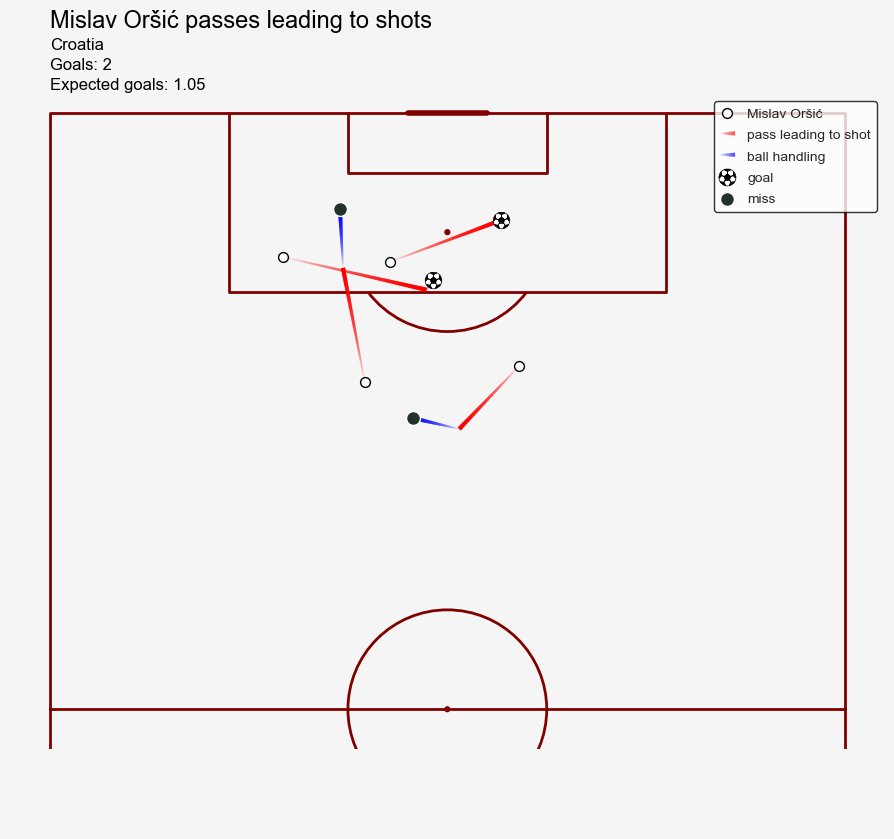

In [71]:
# Plot the passes of a player with the function
plot_passes(pass_shot_regular,'Harry Kane','England')
plot_passes(pass_shot_regular,'Ousmane Dembélé','France')
plot_passes(pass_shot_regular,'Theo Bernard François Hernández','France')
plot_passes(pass_shot_regular,'Mislav Oršić','Croatia')
